<a href="https://colab.research.google.com/github/Sharkar96/BHDQN/blob/main/BHDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import random as r
import numpy as np
import math as m
from numpy import linalg
from shapely.geometry import Point, Polygon, LineString
from shapely import affinity
import matplotlib.pyplot as plt
import matplotlib.patches as patches
np.set_printoptions(precision=1)

In [41]:
def point2nparray(p: Point):
  return np.array([p.x, p.y])

Parameters

In [42]:
katt=1
kstr=4
krep=20
p0=3
ps=8
W1=-10
W2=10
W3=-0.2
alpha=-20
gamma=0.95
ts=0.1
eps=1 #distance from the goal to be reached

In [76]:
class Obstacle:
  def __init__(self, o: Point, A):
    self.A=A
    self.o=o
    self.obstacle=None
    self.createObstacle(o, A)

  def contains(self, *arg):
    return self.obstacle.contains(arg)

  def createObstacle(self, o: Point, A):
    th=360*r.random()
    rngLength=r.random()*A

    vertex=[]
    vertex.append(Point(o.x-rngLength/2,o.y-(A/rngLength)/2))
    vertex.append(Point(o.x+rngLength/2,o.y-(A/rngLength)/2))
    vertex.append(Point(o.x+rngLength/2,o.y+(A/rngLength)/2))
    vertex.append(Point(o.x-rngLength/2,o.y+(A/rngLength)/2))

    self.obstacle=affinity.rotate(Polygon(vertex),th)

  def polygon2array(self):
    x,y =self.obstacle.exterior.coords.xy
    return[list(a) for a in zip(x,y)]

  def __str__(self):
    return str(self.obstacle)

In [44]:
class Robot:
  def __init__(self, x, y):
    self.x=x
    self.y=y

  def move(self, force: np.ndarray):
    #moves: E, NE, N, NW, W, SW, S, SE
    moves=['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE']
    possibleMoves= np.array([[1,0],
                             [0.707,0.707],
                             [0,1],
                             [-0.707,0.707],
                             [-1,0],
                             [-0.707,-0.707],
                             [0,-1],
                             [0.707,-0.707]]
                            )

    chosenMove=np.argmax(np.dot(force, possibleMoves.T))
    self.x=self.x + ts*possibleMoves[chosenMove][0]*linalg.norm(force)
    self.y=self.y + ts*possibleMoves[chosenMove][1]*linalg.norm(force)
    print(moves[chosenMove], end=' ')
    print(np.array([self.x, self.y]))
    return

  def __str__(self):
    return str(np.array([self.x,self.y]))

In [85]:
class Maze:
  def __init__(self, A):
    self.l=m.sqrt(A)
    self.coordinates=np.array([[0,0],
                              [self.l,0],
                              [self.l,self.l],
                              [0,self.l]])
    self.obstacles=[]
    self.goals=[]
    self.robot=None

#WHAT ABOUT THE NORMALIZATION OF THE POTENTIAL FIELD?
  def gravitationalForce(self):
    robotPosition=np.array([self.robot.x, self.robot.y])
    resultingF=np.array([0, 0])
    for i in self.goals:
      #attractive force
      normalAttF= -katt*(robotPosition - point2nparray(i))
      #black hole force
      blackHoleF=np.array([0, 0])
      #print(linalg.norm(robotPosition-point2nparray(i)))  #to test blackhole activation
      if linalg.norm(robotPosition-point2nparray(i))<=ps:
        blackHoleF= kstr*(-(robotPosition - point2nparray(i))) #adding ps break the implementation

      resultingF= resultingF + normalAttF + blackHoleF
    #TODO: OBSTACLE REPULSIVE FORCE
    return resultingF

  #it assumes just 1 robot
  def isGoalReached(self):
    robotPosition= np.array([self.robot.x, self.robot.y])
    for goal in self.goals:
      if linalg.norm(point2nparray(goal)-robotPosition)<=eps:
        return True

    return False

  #check if a goal spawned inside an obstacle
  def isGoalOccluded(self, p: Point):
    for i in self.obstacles:
      if i.contains(p):
        return True
    return False

  #check if the obstacle spawned over a goal
  def isObstacleOccluding(self, p: Polygon):
    for i in self.goals:
      if p.contains(i):
        return True
    return False

  def spawnRobot(self, x=None, y=None):
      if x is not None and y is not None:
        if self.isGoalOccluded(Point(x,y)):
          print('unavailable position')
          return
        else:
          self.robot=Robot(x,y)
      else:
        candidate=Point(r.random()*self.l,r.random()*self.l)
        while self.isGoalOccluded(candidate):
          candidate=Point(r.random()*self.l,r.random()*self.l)
        self.robot=Robot(candidate.x,candidate.y)

  def addGoals(self,n=1):
    for i in range(n):
      candidate=Point(r.random()*self.l, r.random()*self.l)
      while self.isGoalOccluded(candidate):
        candidate=Point(r.random()*self.l, r.random()*self.l)
      self.goals.append(candidate)

  def addObstacles(self, n=1):
    #maximum area is 10% of entire maze
    maxA=0.1
    for i in range(n):
      candidate=Obstacle(o= Point(r.random()*self.l,r.random()*self.l),
                                     A= self.l*self.l*maxA*r.random())
      while self.isObstacleOccluding(candidate):
        candidate=Obstacle(o= Point(r.random()*self.l,r.random()*self.l),
                                     A= self.l*self.l*maxA*r.random())
      self.obstacles.append(candidate)

  def print(self):
    print('coordinates: '+ str(self.coordinates))
    print('-------------------')
    print('robot: ' + str(self.robot))
    print('-------------------')
    print('goals: ')
    for i in self.goals:
      print(point2nparray(i))
    print('-------------------')
    print('obstacles: ')
    for i in self.obstacles:
      print(i)
    print('-------------------')

  def plot(self):
    plt.clf()
    #plot the maze
    rectangle = patches.Rectangle((0,0), self.l, self.l,
                              linewidth=1, edgecolor='b', facecolor='none')
    plt.gca().add_patch(rectangle)
    #plot robot
    plt.scatter(self.robot.x, self.robot.y, c='b', marker='o', label='Robot')
    #plot goals
    for goal in self.goals:
         plt.scatter(goal.x, goal.y, c='g', marker='x', label='Goal')
    #plot obstacles
    for obs in self.obstacles:
      poly=patches.Polygon(obs.polygon2array(),edgecolor='r', facecolor='r')
      plt.gca().add_patch(poly)
    plt.xticks(range(0, m.ceil(self.l),2))
    plt.yticks(range(0, m.ceil(self.l),2))
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.legend()
    plt.draw()
    plt.pause(0.1)


coordinates: [[ 0.   0. ]
 [31.6  0. ]
 [31.6 31.6]
 [ 0.  31.6]]
-------------------
robot: [1 1]
-------------------
goals: 
[20.1 24.1]
-------------------
obstacles: 
POLYGON ((16.844941246504938 -10.957496796776368, 16.668351582711665 17.570086158494686, 15.554508859042588 17.563191318774138, 15.73109852283586 -10.96439163649692, 16.844941246504938 -10.957496796776368))
-------------------


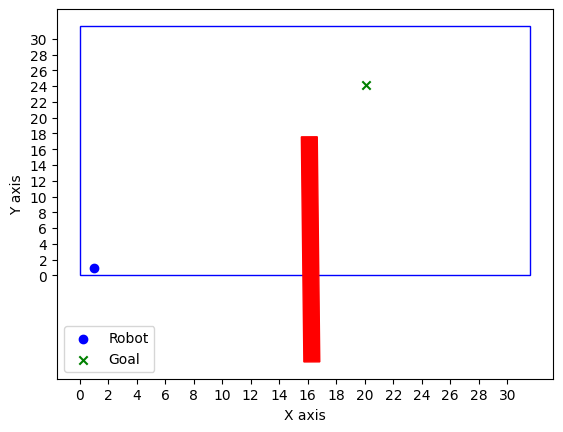

In [86]:
maze=Maze(1000)
maze.addGoals(1)
maze.addObstacles(1)
maze.spawnRobot(x=1,y=1)
maze.print()
maze.plot()


NE [3.1 3.1]


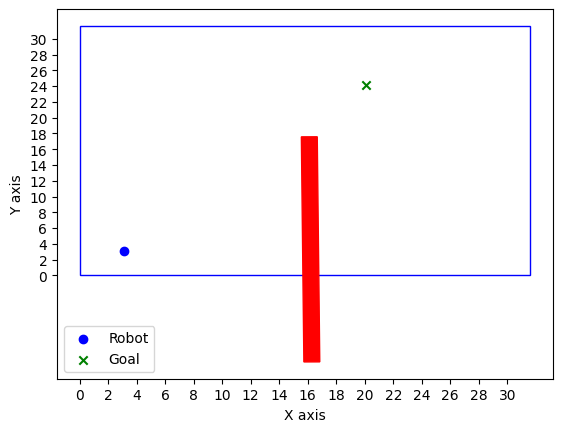

NE [5. 5.]


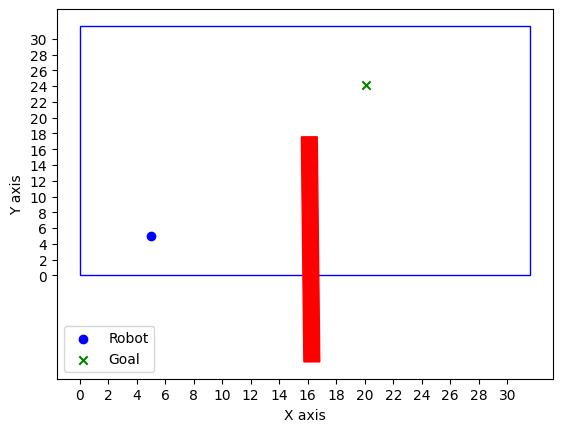

NE [6.7 6.7]


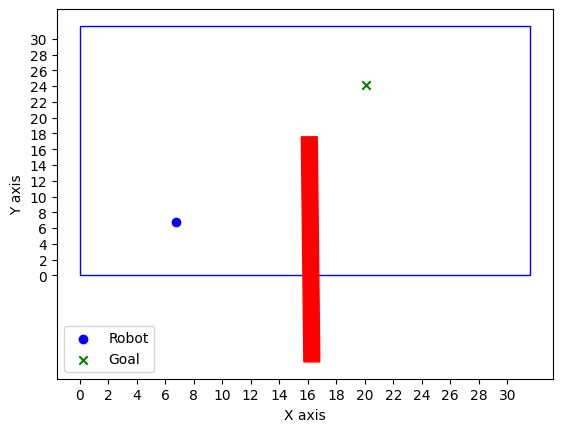

NE [8.3 8.3]


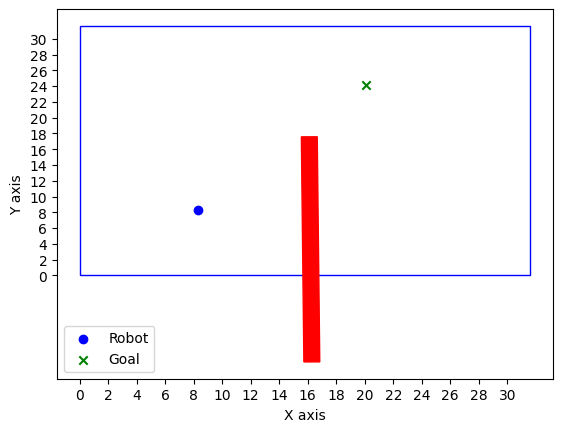

NE [9.7 9.7]


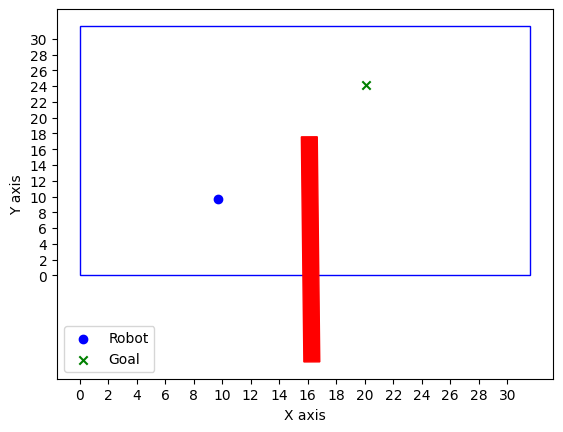

NE [10.9 10.9]


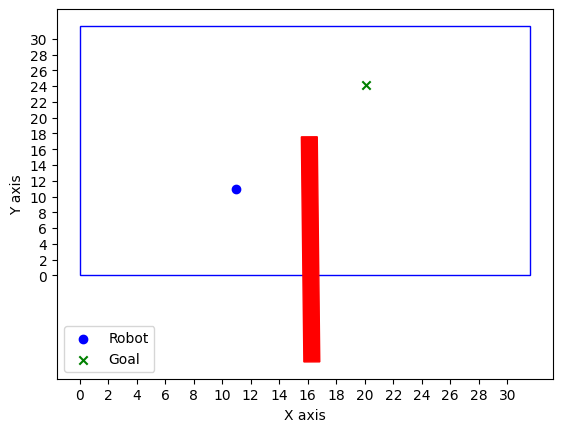

NE [12.1 12.1]


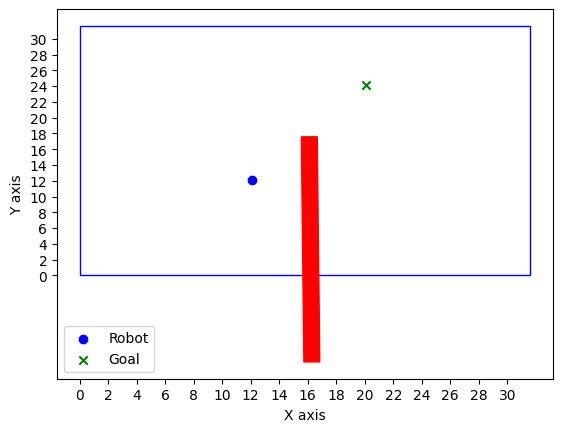

NE [13.1 13.1]


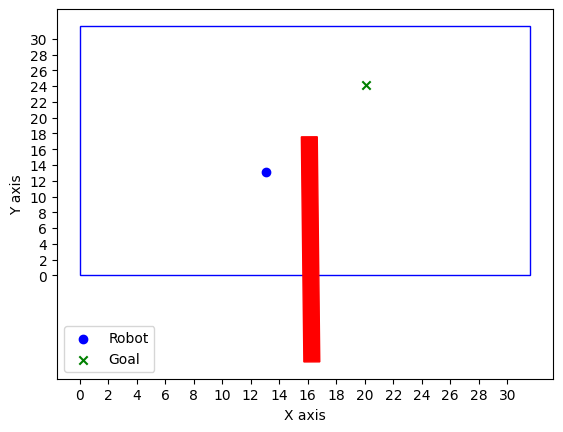

NE [14. 14.]


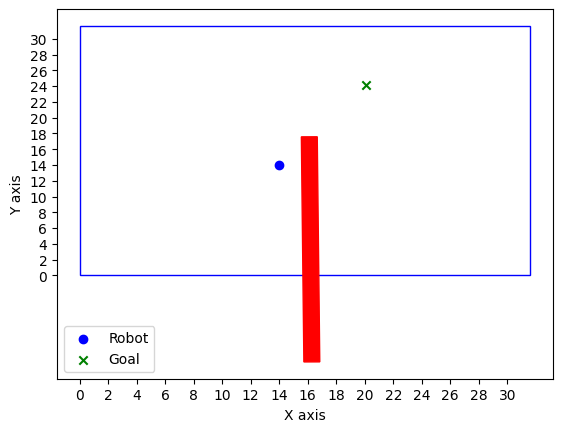

NE [14.8 14.8]


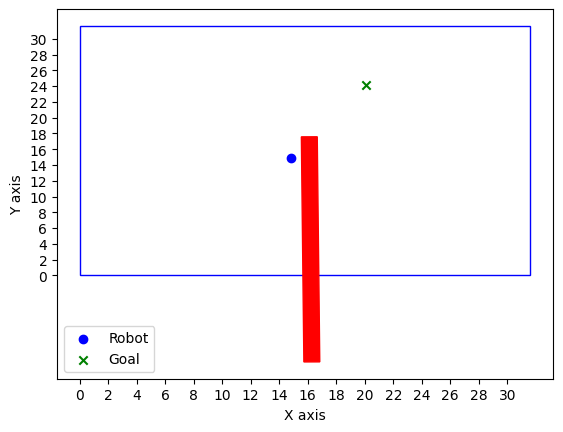

NE [15.6 15.6]


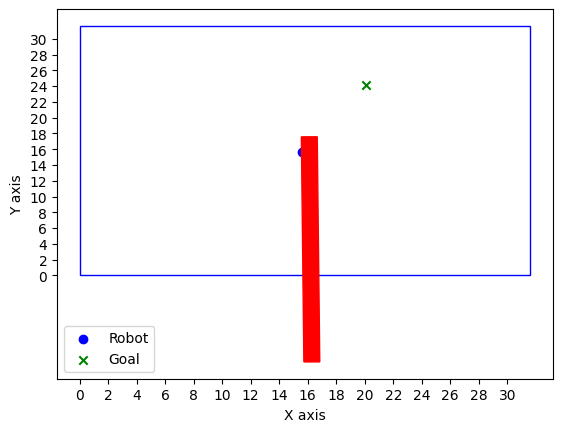

NE [16.3 16.3]


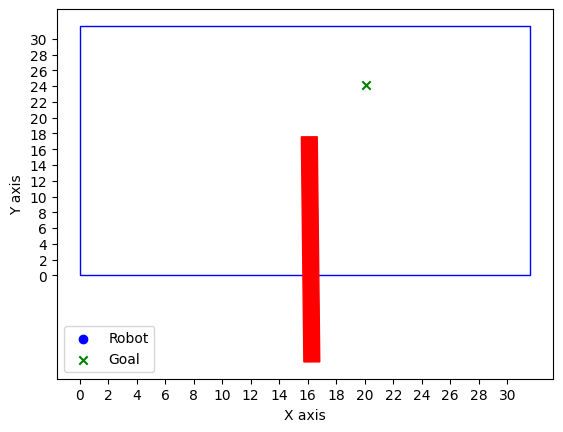

NE [16.9 16.9]


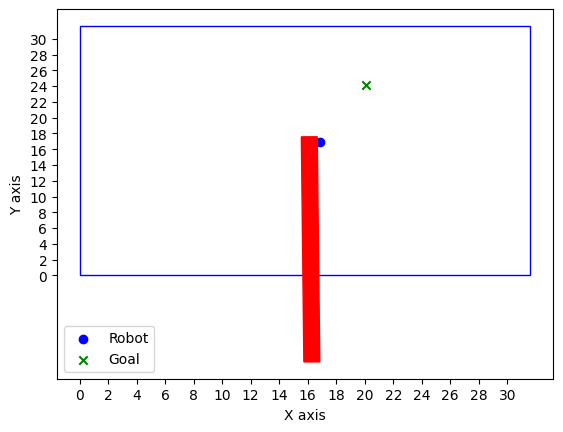

NE [19.7 19.7]


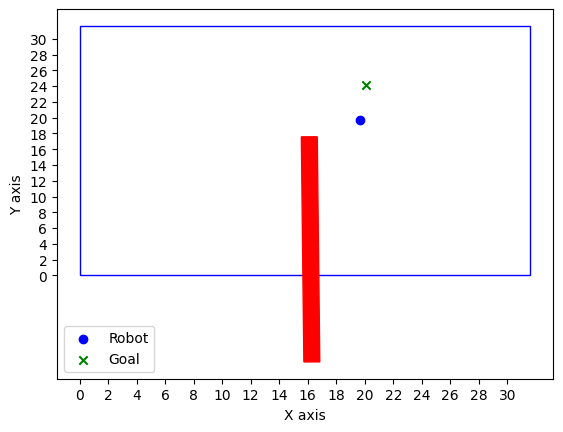

N [19.7 21.9]


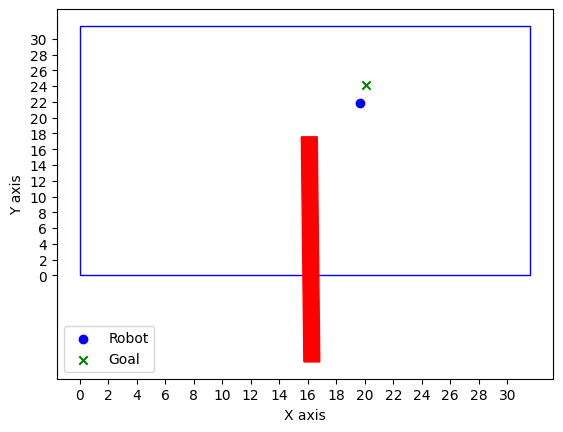

N [19.7 23. ]


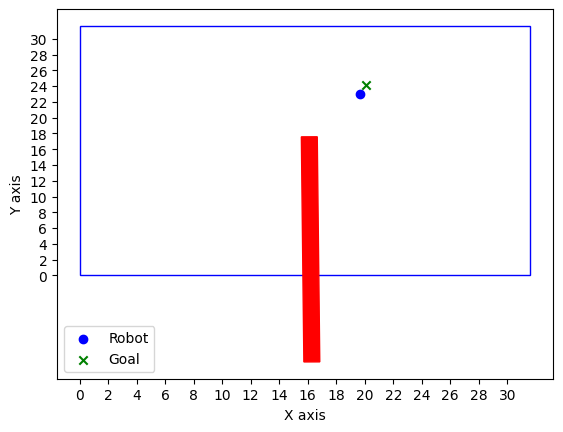

N [19.7 23.6]


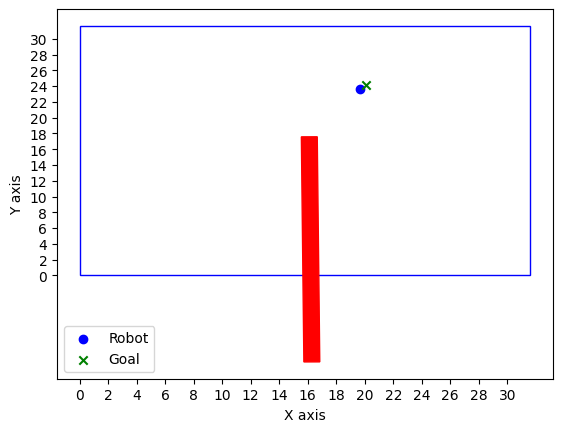

the goal was reached


In [87]:

epochs=50
plt.ion()
for epoch in range(epochs):
  if maze.isGoalReached():
    print('the goal was reached')
    break
  else:
    maze.robot.move(maze.gravitationalForce())
    maze.plot()

plt.ioff()
plt.show()
